# A review on (Bayesian) regression techniques

__Objective:__ apply different (Bayesian) techniques to a regression problem to get a feel for how they work.

Source: [here](https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb).

In [838]:
from math import pi
import sys
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from keras_utilities import NEpochsLogger, append_to_full_history, nll
from tfp_utilities import plot_prediction_distr

tfd = tfp.distributions

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data

We generate data divided into 3 consecutive regions, with the first and the last being exactly linear (datapoints lie on a straight line). In the second regions points are distributed according to a Gaussian centered on the sum of a sine and a linear function, with standard eviation **depending on the amplitude of $\sin$: this create heteroskedasticity: the standard deviation of the data is bigger at the max and min points of the sinusoid.

In [495]:
def generate_data(n_samples_sine=300, n_samples_linear=60):
    """
    Generates synthetic data with x in [-3, 3], divided in 3
    consecutive regions:
        1. A linear part.
        2. A linear part added to a sine part with Gaussian noise
           with standar deviation proportional to the absolute value
           of the value of the sine part alone.
        3. Another linear part.
    """
    n_samples_sine = 156
    n_samples_linear = 60
    
    x_sin_min = 0.
    x_sin_max = 6. * tf.constant(pi)
    x_min = x_sin_min - 3.
    x_max = x_sin_max + 3.
    
    x = tf.concat(
        [
            tf.linspace(x_min, x_sin_min, n_samples_linear),
            tf.linspace(x_sin_min, x_sin_max, n_samples_sine),
            tf.linspace(x_sin_max, x_max, n_samples_linear)
        ],
        axis=0
    )
    
    
    
    x_sin = tf.linspace(0., 2. * tf.constant(pi), n_samples_sine)
    y_sin = 3. * tf.math.sin(x_sin) + tf.squeeze(tfd.Normal(loc=tf.zeros_like(x_sin),scale=0.15 * tf.abs(3. * tf.math.sin(x_sin))).sample())
    
    y = tf.concat(
        [
            tf.zeros(shape=(n_samples_linear,)),
            y_sin,
            tf.zeros(shape=(n_samples_linear,))
        ],
        axis=0
    ) + 0.1 * x + 1.

    return x[..., tf.newaxis], y

Text(0.5, 1.0, 'Synthetic data')

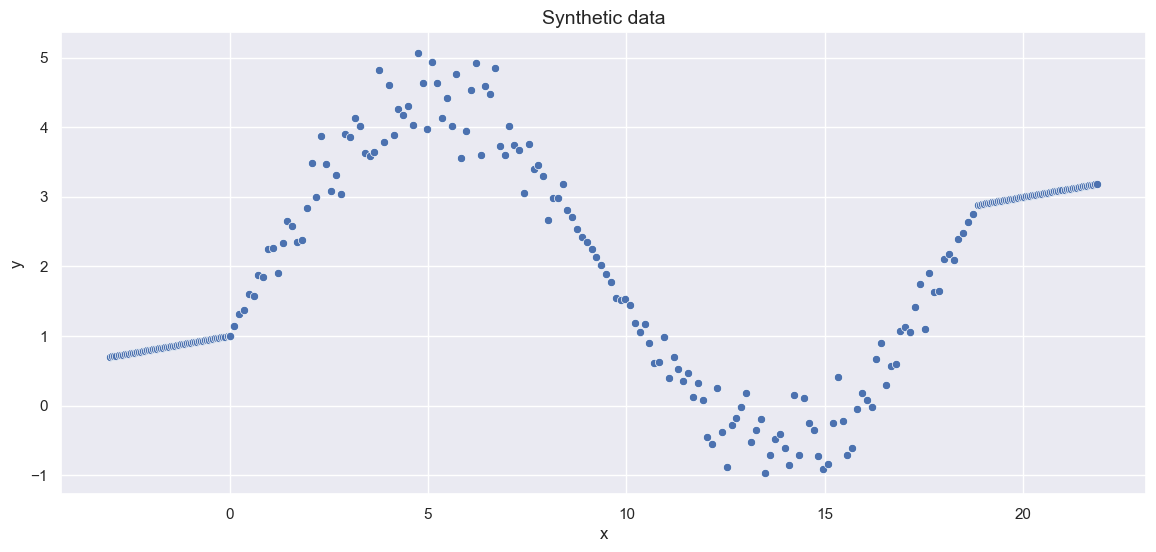

In [496]:
x, y = generate_data()

fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x[:, 0],
    y=y
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic data', fontsize=14)

## Model: NN with final probabilistic layer

A NN with non-Bayesian hidden layer but with a final probabilistic layer is able to capture the aleatoric uncertainty in the data, but not the epistemic one. In this case, the output probabilistic layer generates Gaussian distributions with both their means and their standard deviations parametrized by the neural network. If the NN is sufficiently flexible, we should be able to model heteroskedasticity this way (i.e. the fact that the aleatoric uncertainty - the standard deviation of the data-generating distribution - depends on the regressor $x$ itself).

In [780]:
model_probabilistic = tf.keras.Sequential([
    BatchNormalization(),
    Dense(units=40, activation='relu'),
    BatchNormalization(),
    Dense(units=40, activation='relu'),
    Dense(units=2),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=tf.math.softplus(t[..., 1:]))
    )
])

history_probabilistic_full = {}

In [782]:
learning_rate = 1e-3

optimizer_probabilistic = tf.keras.optimizers.SGD(learning_rate=learning_rate)


model_probabilistic.compile(
    optimizer=optimizer_probabilistic,
    loss=nll,
    metrics=['mse'],
)

model_probabilistic(x[:1, ...])

model_probabilistic.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (1, 1)                    4         
 chNormalization)                                                
                                                                 
 dense_167 (Dense)           (1, 40)                   80        
                                                                 
 batch_normalization_5 (Bat  (1, 40)                   160       
 chNormalization)                                                
                                                                 
 dense_168 (Dense)           (1, 40)                   1640      
                                                                 
 dense_169 (Dense)           (1, 2)                    82        
                                                                 
 distribution_lambda_45 (Di  ((1, 1),                

In [868]:
# To change the value of the learning rate after training for a set
# number of epochs.
# K.set_value(model_probabilistic.optimizer.learning_rate, 1e-3)

In [804]:
epochs = 1000

history_probabilistic = model_probabilistic.fit(
    x=x,
    y=y,
    epochs=epochs,
    verbose=0,
    callbacks=[NEpochsLogger(100)]
)

history_probabilistic_full = append_to_full_history(history_probabilistic, history_probabilistic_full)

Epoch: 0 - loss: 0.09362727403640747 - mse: 0.38289380073547363
Epoch: 100 - loss: 0.26954397559165955 - mse: 0.5293723940849304
Epoch: 200 - loss: 0.8098716735839844 - mse: 0.578549861907959
Epoch: 300 - loss: 0.9221019744873047 - mse: 0.6801710724830627
Epoch: 400 - loss: 0.8982652425765991 - mse: 0.638327956199646
Epoch: 500 - loss: 0.37474778294563293 - mse: 0.4565463066101074
Epoch: 600 - loss: 0.24885280430316925 - mse: 0.5130807757377625
Epoch: 700 - loss: 1.5810215473175049 - mse: 3.6344351768493652
Epoch: 800 - loss: 0.3187498152256012 - mse: 0.45927152037620544
Epoch: 900 - loss: 0.13460665941238403 - mse: 0.4313422441482544


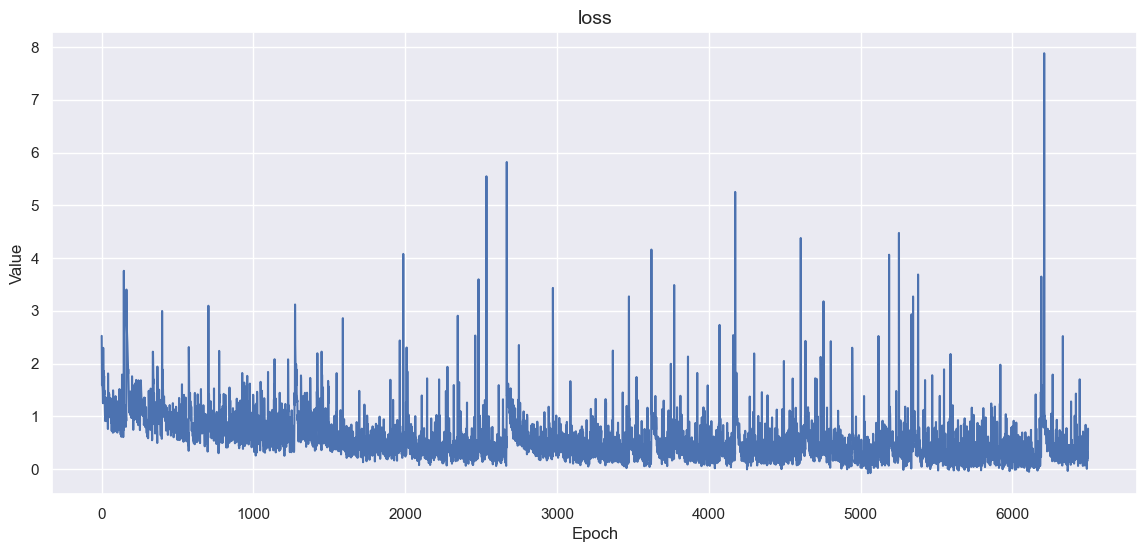

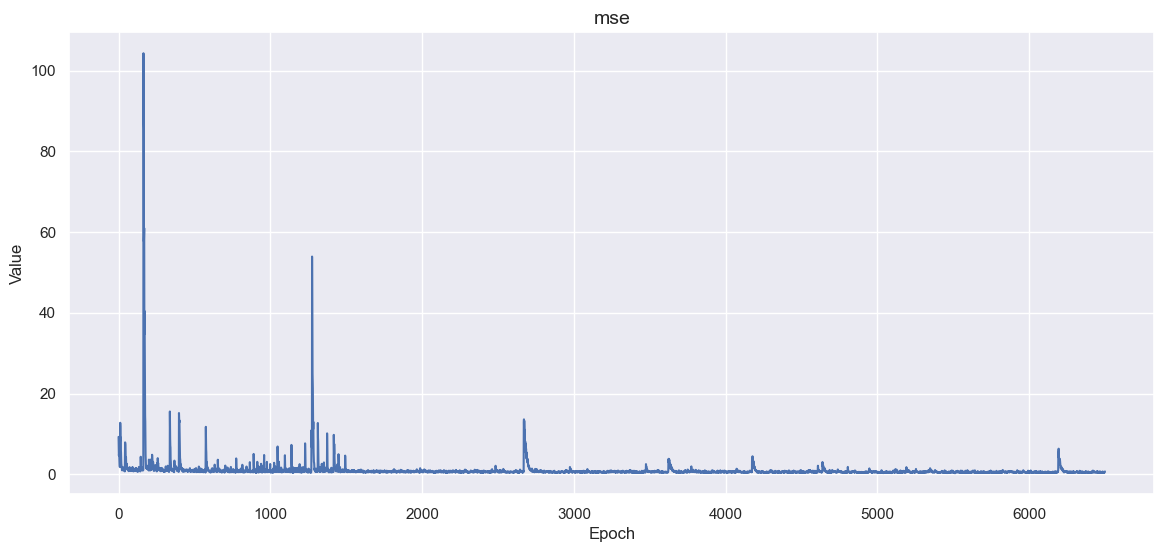

In [805]:
plot_history(history_probabilistic_full)

Observations: once trained, a sufficiently flexible model exhibits the following features,
- The estimated aleatoric uncertainty is bigger in the central sinusoidal region (where dataponts are more spread), while in the initial and final regions (exact straight lines) the estimate is small.
- Extrapolation beyond the region where the data lies just carries on the linear trend with the corresponding small aleatoric uncertainty. This is **not desirable** as we'd like the model to be very uncertain when extrapolating to regions in which it's seen no data at all (the estimate of epistemic uncertainty is needed to do this).

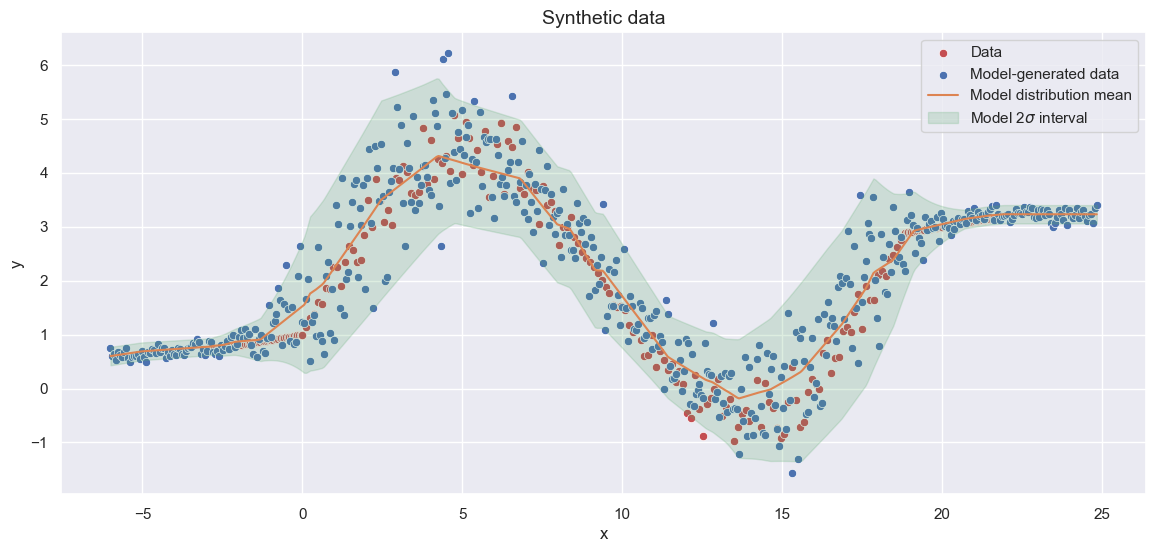

In [837]:
plot_prediction_distr(
    x,
    y,
    model_probabilistic,
    x_plot_min=x.numpy().min() - 3.,
    x_plot_max=x.numpy().max() + 3.
)

In [1029]:
# model_probabilistic.save('../models/regression_review_probabilistic_model.tf')

INFO:tensorflow:Assets written to: ../models/regression_review_probabilistic_model.tf/assets


INFO:tensorflow:Assets written to: ../models/regression_review_probabilistic_model.tf/assets


## Model: Bayesian NN with VI

In [909]:
from tfp_utilities import get_divergence_fn


divergence_fn = get_divergence_fn(norm_factor=x.shape[0])

In [1021]:
model_bayesian_vi = tf.keras.Sequential([
    BatchNormalization(),
    tfp.layers.DenseLocalReparameterization(units=40, activation='relu', kernel_divergence_fn=divergence_fn),
    BatchNormalization(),
    tfp.layers.DenseLocalReparameterization(units=40, activation='relu', kernel_divergence_fn=divergence_fn),
    tfp.layers.DenseLocalReparameterization(units=2, kernel_divergence_fn=divergence_fn),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :1], scale=tf.math.softplus(t[..., 1:])),
            reinterpreted_batch_ndims=1
        )
    )
])

history_bayesian_vi_full = {}

In [1022]:
learning_rate = 1e-3

optimizer_bayesian_vi = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=False)

model_bayesian_vi.compile(
    optimizer=optimizer_bayesian_vi,
    loss=nll,
    metrics=['mse']
)

model_bayesian_vi(x)

model_bayesian_vi.summary()

/Users/Ema/anaconda3/envs/bayesian-explorations-2/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/Ema/anaconda3/envs/bayesian-explorations-2/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_46 (Ba  (276, 1)                  4         
 tchNormalization)                                               
                                                                 
 dense_local_reparameteriza  (276, 40)                 120       
 tion_60 (DenseLocalReparam                                      
 eterization)                                                    
                                                                 
 batch_normalization_47 (Ba  (276, 40)                 160       
 tchNormalization)                                               
                                                                 
 dense_local_reparameteriza  (276, 40)                 3240      
 tion_61 (DenseLocalReparam                                      
 eterization)                                        

In [1023]:
# To change the value of the learning rate after training for a set
# number of epochs.
# K.set_value(model_bayesian_vi.optimizer.learning_rate, 1e-2)

Epoch: 0 - loss: 16.94519805908203 - mse: 2.1262128353118896
Epoch: 5 - loss: 17.009441375732422 - mse: 2.168010950088501
Epoch: 10 - loss: 16.901655197143555 - mse: 1.8714560270309448
Epoch: 15 - loss: 16.898120880126953 - mse: 1.963660478591919
Epoch: 20 - loss: 16.932096481323242 - mse: 2.3554654121398926
Epoch: 25 - loss: 16.917980194091797 - mse: 1.9972175359725952
Epoch: 30 - loss: 16.90723419189453 - mse: 2.0102040767669678
Epoch: 35 - loss: 16.87272071838379 - mse: 1.7520970106124878
Epoch: 40 - loss: 16.968280792236328 - mse: 2.412874698638916
Epoch: 45 - loss: 17.045127868652344 - mse: 2.2197322845458984
Epoch: 50 - loss: 16.99724578857422 - mse: 2.1772048473358154
Epoch: 55 - loss: 17.10198974609375 - mse: 2.7329392433166504
Epoch: 60 - loss: 16.9919490814209 - mse: 2.314159393310547
Epoch: 65 - loss: 16.928577423095703 - mse: 2.433737277984619
Epoch: 70 - loss: 16.932262420654297 - mse: 2.2882437705993652
Epoch: 75 - loss: 16.954219818115234 - mse: 2.0640273094177246
Epoch:

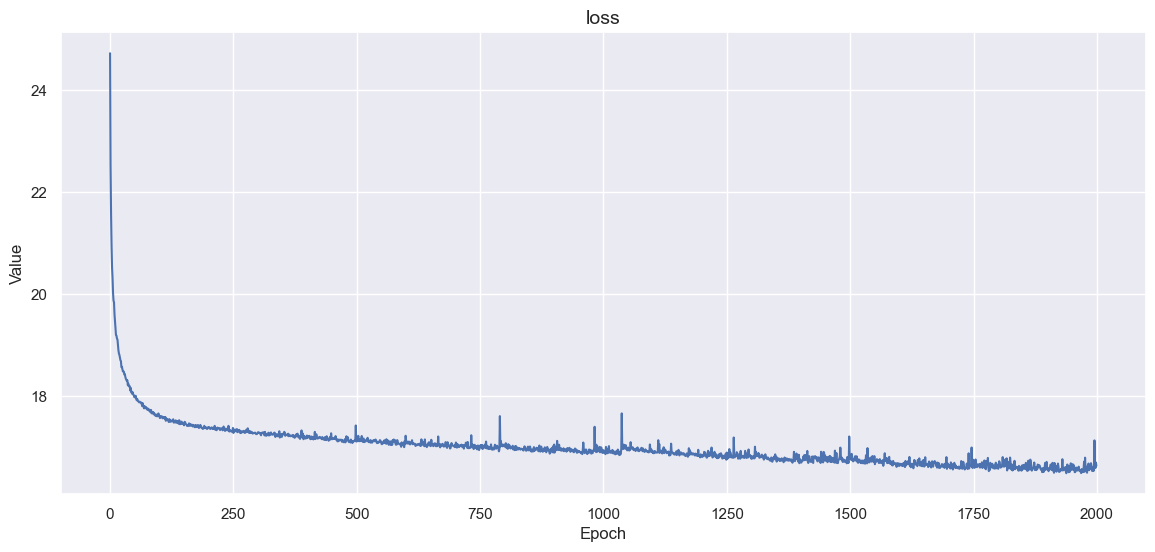

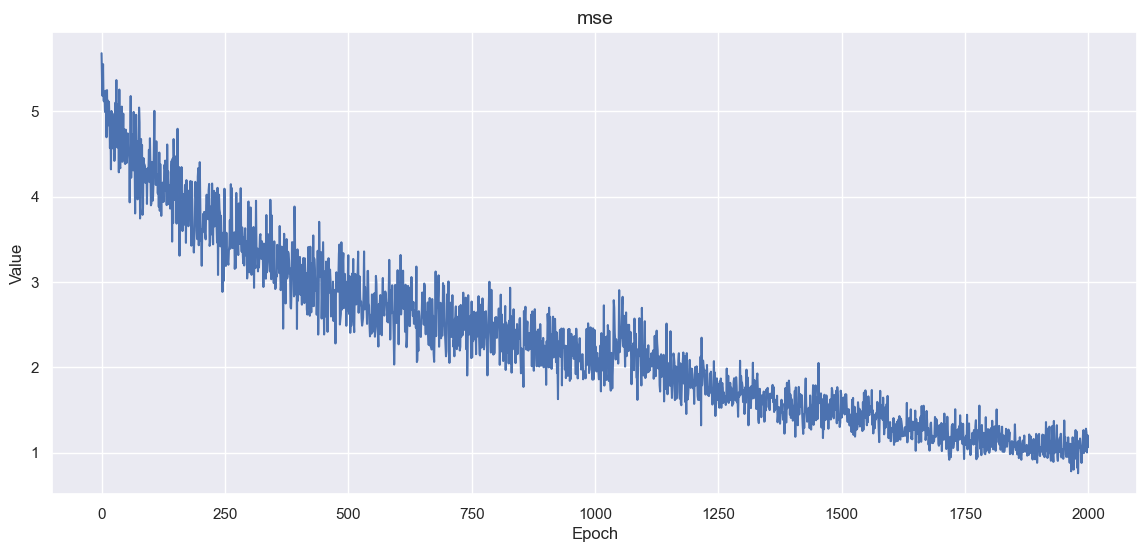

In [1027]:
epochs = 1000

history_bayesian_vi = model_bayesian_vi.fit(
    x=x,
    y=y,
    epochs=epochs,
    callbacks=[NEpochsLogger(5)],
    verbose=0,
    batch_size=128
)

history_bayesian_vi_full = append_to_full_history(history_bayesian_vi, history_bayesian_vi_full)

plot_history(history_bayesian_vi_full)

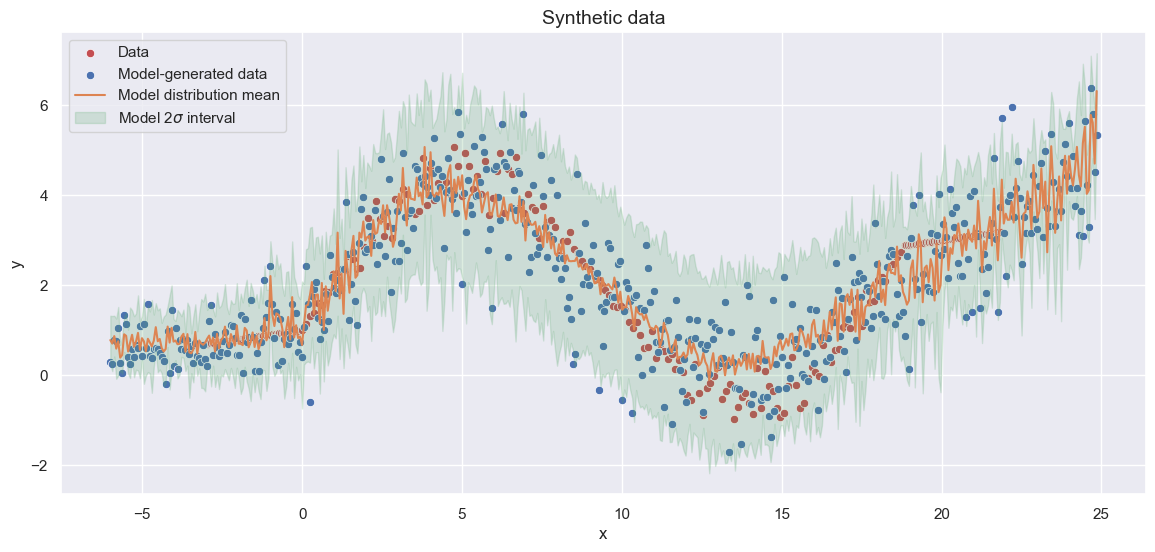

In [1028]:
plot_prediction_distr(
    x,
    y,
    model_bayesian_vi,
    x_plot_min=x.numpy().min() - 3.,
    x_plot_max=x.numpy().max() + 3.
)